In [1]:
#error with load.pickle
#!pip install "pandas<2.0.0"
#!pip install dgb
#!pip install dgp

## Generating the ground truth adjacency matrix 

In [2]:
import networkx as nx
import numpy as np
#import dgb
#import dgp
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import os 
path = os.getcwd()
path

'/home/choudhar'

In [4]:
filename = os.path.join(path, '../data/data_8n_100ts_30N_graphs.gpickle')

with open(filename, 'rb') as f:
    graph = pickle.load(f)

In [5]:
num_time_slices = 100 #number of time slices in the folded dataset 
num_vars = 8 #number of variables per time slice

In [6]:
#graph
#graph.causal_graph.nodes
#graph.causal_graph.edges

In [7]:
## Removing the noise variables from the graph
node_list = [node for node in graph.causal_graph.nodes if not node.startswith('S')]  
# No edges originating from noise.
edge_list = [edge for edge in graph.causal_graph.edges if not edge[0].startswith('S')]

In [8]:
L = graph.get_feature_nodes() + graph.get_target_nodes()

In [9]:
# renaming the nodes and edges 

renamed_nodes = []
for node in L:
    if node.endswith('_t'):
        renamed_node = node.replace('_t', f'_t_{num_time_slices-1}')
    else: 
        for i in range(1, num_time_slices): 
            if node.endswith(f'_t{-i}'):
                renamed_node = node.replace(f'_t{-i}', f'_t_{-i+num_time_slices-1}')
    
    renamed_nodes.append(renamed_node)

renamed_edges = []
for tuple in edge_list:
    renamed_edge = ()
    for node in tuple:
        if node.endswith('_t'):
            renamed_node = node.replace('_t', f'_t_{num_time_slices-1}')
        else: 
            for i in range(1, num_time_slices): 
                if node.endswith(f'_t{-i}'):
                    renamed_node = node.replace(f'_t{-i}', f'_t_{-i+num_time_slices-1}')
        renamed_edge = renamed_edge+(renamed_node,)
    renamed_edges.append(renamed_edge)


In [10]:
G_new = nx.DiGraph()
G_new.add_nodes_from(renamed_nodes)
G_new.add_edges_from(renamed_edges)

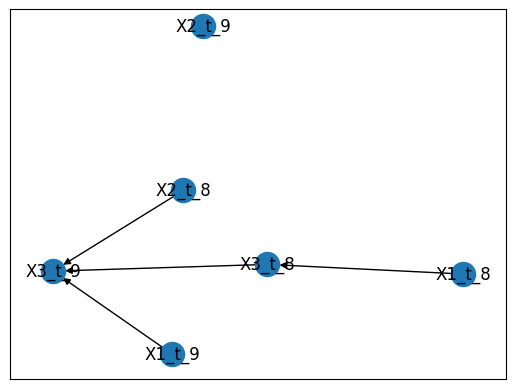

In [11]:
nx.draw_networkx(G_new)

The adjacency matrix needs to have the same variables order as the data 

In [12]:
data_dbn_format = pd.read_csv(os.path.join(path, 'synthetic_datasets/data_3n_10ts_30N.csv'))
order_from_datafile = list(data_dbn_format.columns)

In [13]:
# getting the graph's adj matrix with the right order from the data 
m = nx.adjacency_matrix(G_new, nodelist=order_from_datafile[-num_vars*2:])
adj = m.todense()

In [14]:
adj_mat_prior = adj[:num_vars,:num_vars]
adj_mat_transition = adj[:num_vars, num_vars:2*num_vars]

In [15]:
# under the stationary assumption
adj_final = np.zeros((num_vars*num_time_slices, num_vars*num_time_slices))

for k in range(num_time_slices):
    #filling the prior matrix
    adj_final[num_vars*k:num_vars*(k+1),num_vars*k:num_vars*(k+1)] = adj_mat_prior 
    #the transition 
    if k < num_time_slices - 1:
        adj_final[num_vars*k:num_vars*(k+1),num_vars*(k+1):num_vars*(k+2)] = adj_mat_transition

In [16]:
pd.DataFrame(adj_final).to_csv(os.path.join(path, 'synthetic_datasets/adj_3n_10ts_30N.csv'))